In [1]:
"""
based on: https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection
"""

'\nbased on: https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection\n'

In [2]:
# Install all requirements needed to train this model and track it in MLFlow.

!pip install pip numpy pandas tensorflow matplotlib seaborn tf2onnx onnxruntime scikit-learn -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import the dependencies we need to run the code.

import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import tf2onnx
from sklearn.linear_model import LogisticRegression

2023-05-04 15:45:37.422647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 15:45:37.425958: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 15:45:37.489847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 15:45:37.491288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 15:45:38.667783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
# Get the environment variable for how to reach MLFlow.
# The general format is http://<route-to-mlflow>:<port> where you replace <route-to-mlflow> and <port> with specifics for where your MLFlow instance is set up and/or exposed.

# MLFLOW_ROUTE = os.getenv("MLFLOW_ROUTE")

In [ ]:
# Load the CSV data which we will use to train the model.
# It contains the following fields:
#   distancefromhome - The distance from home where the transaction happened.
#   distancefromlast_transaction - The distance from last transaction happened.
#   ratiotomedianpurchaseprice - Ratio of purchased price compared to median purchase price.
#   repeat_retailer - If it's from a retailer that already has been purchased from before.
#   used_chip - If the (credit card) chip was used.
#   usedpinnumber - If the PIN number was used.
#   online_order - If it was an online order.
#   fraud - If the transaction is fraudulent.

Data = pd.read_csv('../data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
# Set the input (X) and output (Y) data. 
# The only output data we have is if it's fraudulent or not, and all other fields go as inputs to the model.

X = Data.drop(columns = ['fraud'])
y = Data['fraud']

# Split the data into training and testing sets so we have something to test the trained model with.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. This means that the data will be between -1 and 1, which makes it a lot easier for the model to learn than random potentially large values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), we set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Build the model, the model we build here is a simple fully connected deep neural network, containing 3 hidden layers and one output layer.

model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# Set up tracking to MLFlow by using the route from earlier. We call the experiment and model DNN-credit-fraud.
# We also enable autologging for MLFlow so we don't have to manually log the model or any metrics besides custom ones.

# mlflow.set_tracking_uri(MLFLOW_ROUTE)
# mlflow.set_experiment("DNN-credit-card-fraud")
# mlflow.tensorflow.autolog(registered_model_name="DNN-credit-card-fraud")

Epoch 1/2
20000/20000 [==============================] - 80s 4ms/step - loss: 0.0952 - accuracy: 0.9594 - val_loss: 0.0792 - val_accuracy: 0.9674
Epoch 2/2
6250/6250 [==============================] - 10s 1ms/step


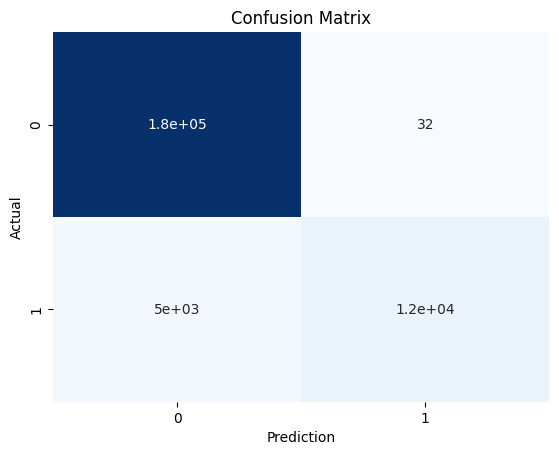

true -: 182487
false +: 32
false -: 4993
true +: 12488


2023-05-04 15:48:34.513607: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-04 15:48:34.513983: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-04 15:48:34.625961: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-04 15:48:34.626355: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [ ]:
# Train the model.
# We wrap the training with an mlflow wrapper to signify that this is an experiment run.
# We also define a few more metrics at the very bottom to track the confusion matrix in MLFlow.

epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val),y_val), \
                    verbose = True, class_weight = class_weights)

y_pred_temp = model.predict(scaler.transform(X_test)) 

threshold = 0.995

y_pred = np.where(y_pred_temp > threshold, 1,0)
c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

t_n, f_p, f_n, t_p = c_matrix.ravel()
print(f"true -: {t_n}")
print(f"false +: {f_p}")
print(f"false -: {f_n}")
print(f"true +: {t_p}")

model_proto,_ = tf2onnx.convert.from_keras(model)

In [ ]:
import onnx
model_filename = 'fraud.onnx'
onnx.save(model_proto, model_filename)

In [ ]:
import s3_utils
import os

In [ ]:
print(f'AWS_DEFAULT_REGION = {os.environ["AWS_DEFAULT_REGION"]}')
s3_utils.list_buckets(os.environ['AWS_DEFAULT_REGION'])

AWS_DEFAULT_REGION = us-east-2
Existing buckets:
  bk-mlflow
  bk-modeltest
  koz-scratch
  koz-triton-test
  nb.1669857071699.apps.ocp.sandbox2000.opentlc.com
  nb.1673013763495.apps.ocp.sandbox2000.opentlc.com
  nb.1682605730000.apps.ocp.sandbox2000.opentlc.com
  ocp-z9trm-image-registry-us-east-1-ssfngdkkhmjdyjygykbhnrxkpwu


In [ ]:
bucket_name = os.environ['AWS_S3_BUCKET']
print(f'bucket_name: {bucket_name}')
# s3_utils.delete_bucket(bucket_name)
s3_utils.create_bucket(bucket_name, os.environ['AWS_DEFAULT_REGION'])

bucket_name: bk-fraud


True

In [ ]:
s3_utils.upload_file(model_filename, bucket_name)

True